In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

from torch.utils.data import DataLoader, random_split

# Transformations for training and validation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

# Load the datasets
full_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)

# Split the training set into training and validation sets
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Define the data loaders
trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=100,
                       shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=100,
                        shuffle=False, num_workers=2)

Using device: cuda


100%|██████████| 169M/169M [00:05<00:00, 32.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
from torchvision.models import vgg19

teacher_model = vgg19(pretrained=True)

num_features = teacher_model.classifier[6].in_features
teacher_model.classifier[6] = nn.Linear(num_features, 100)

teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 147MB/s]


In [3]:
def train_teacher(model, trainloader, valloader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer_teacher = optim.SGD(teacher_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs_teacher = 5
teacher_train_losses, teacher_val_losses, teacher_val_accuracies = train_teacher(
    teacher_model, trainloader, valloader, criterion, optimizer_teacher, num_epochs_teacher, device)

Epoch [1/5]
Train Loss: 2.7844
Validation Loss: 2.1377, Validation Accuracy: 41.66%

Epoch [2/5]
Train Loss: 2.0276
Validation Loss: 1.9275, Validation Accuracy: 47.16%

Epoch [3/5]
Train Loss: 1.7629
Validation Loss: 1.7354, Validation Accuracy: 52.36%

Epoch [4/5]
Train Loss: 1.6111
Validation Loss: 1.6583, Validation Accuracy: 54.04%

Epoch [5/5]
Train Loss: 1.4664
Validation Loss: 1.6157, Validation Accuracy: 55.70%



In [5]:
def train_logit_matching(model, teacher_model, trainloader, valloader, optimizer, num_epochs, device, temperature=4.0, alpha=0.1, beta=0.9):
    train_losses = []
    val_losses = []
    val_accuracies = []

    criterion_ce = nn.CrossEntropyLoss()
    criterion_kd = nn.KLDivLoss(reduction='batchmean')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            # Compute losses
            loss_ce = criterion_ce(outputs, targets)
            loss_kd = criterion_kd(
                F.log_softmax(outputs / temperature, dim=1),
                F.softmax(teacher_outputs / temperature, dim=1)
            ) * (temperature ** 2)

            loss = alpha * loss_ce + beta * loss_kd

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion_ce(outputs, targets)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, val_accuracies

In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    losses = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = losses / len(dataloader)
    accuracy = 100. * correct / total
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [7]:
from torchvision.models import vgg11

num_epochs = 5
learning_rate = 0.01

# Copy the student model for training
student_model_lm = vgg11(pretrained=True)
student_model_lm.classifier[6] = nn.Linear(num_features, 100)
student_model_lm = student_model_lm.to(device)

optimizer_lm = optim.SGD(student_model_lm.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Train the model
lm_train_losses, lm_val_losses, lm_val_accuracies = train_logit_matching(
    student_model_lm, teacher_model, trainloader, valloader, optimizer_lm, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:04<00:00, 116MB/s]


Epoch [1/5]
Train Loss: 1.6059
Validation Loss: 2.2162, Validation Accuracy: 39.20%

Epoch [2/5]
Train Loss: 0.8996
Validation Loss: 1.9936, Validation Accuracy: 45.00%

Epoch [3/5]
Train Loss: 0.7261
Validation Loss: 1.8200, Validation Accuracy: 48.96%

Epoch [4/5]
Train Loss: 0.6398
Validation Loss: 1.7851, Validation Accuracy: 50.70%

Epoch [5/5]
Train Loss: 0.5788
Validation Loss: 1.7378, Validation Accuracy: 51.80%



In [8]:
print('Evaluating Logit Matching Model on Test Set:')
lm_test_loss, lm_test_accuracy = evaluate(student_model_lm, testloader, device)

print('\nEvaluating Teacher Model on Test Set:')
teacher_test_loss, teacher_test_accuracy = evaluate(teacher_model, testloader, device)

Evaluating Logit Matching Model on Test Set:
Loss: 1.6724, Accuracy: 53.95%

Evaluating Teacher Model on Test Set:
Loss: 1.5562, Accuracy: 57.11%


In [12]:
teacherB_test_loss = 1.503634374141693
teacherB_test_accuracy = 58.23
teacherB_train_losses = [2.8464131687175143, 1.9864025183699348, 1.7186446084894917, 1.5385188324884935, 1.4261029921472073]
teacherB_val_losses = [2.099898433685303, 1.9228379392623902, 1.6599740314483642, 1.6272436380386353, 1.5875337100028992]
teacherB_val_accuracies = [42.7, 47.54, 54.08, 55.38, 56.74]

lmB_train_losses = [1.7408535206182436, 0.9762329217046499, 0.7840214090591128, 0.6906445983119986, 0.6272612063383515]
lmB_val_losses =  [2.2692494058609007, 1.9759065842628478, 1.869062294960022, 1.7771518516540528, 1.7071607160568236]
lmB_val_accuracies = [39.56, 46.74, 49.96, 51.12, 53.3]
lmB_test_loss = 1.6075777184963227
lmB_test_accuracy = 55.58

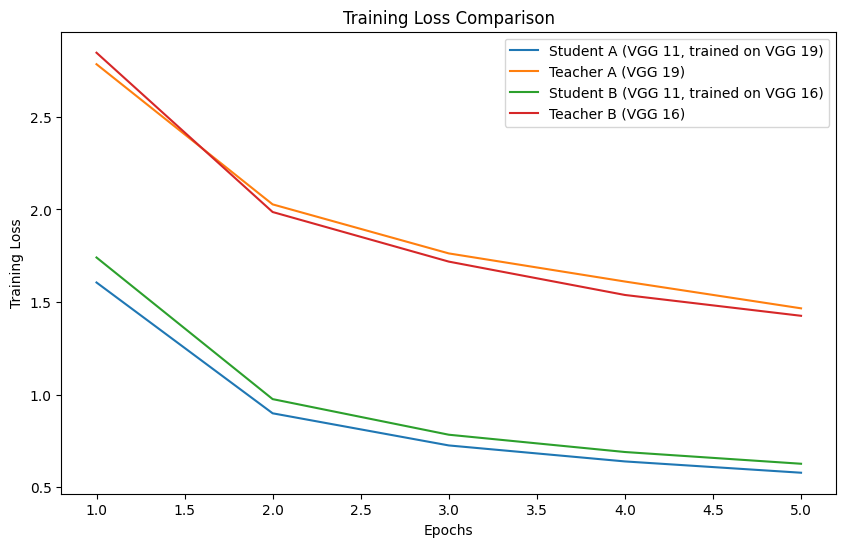

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(lm_train_losses) + 1)

# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, lm_train_losses, label="Student A (VGG 11, trained on VGG 19)")
plt.plot(epochs, teacher_train_losses, label="Teacher A (VGG 19)")
plt.plot(epochs, lmB_train_losses, label="Student B (VGG 11, trained on VGG 16)")
plt.plot(epochs, teacherB_train_losses, label="Teacher B (VGG 16)")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()


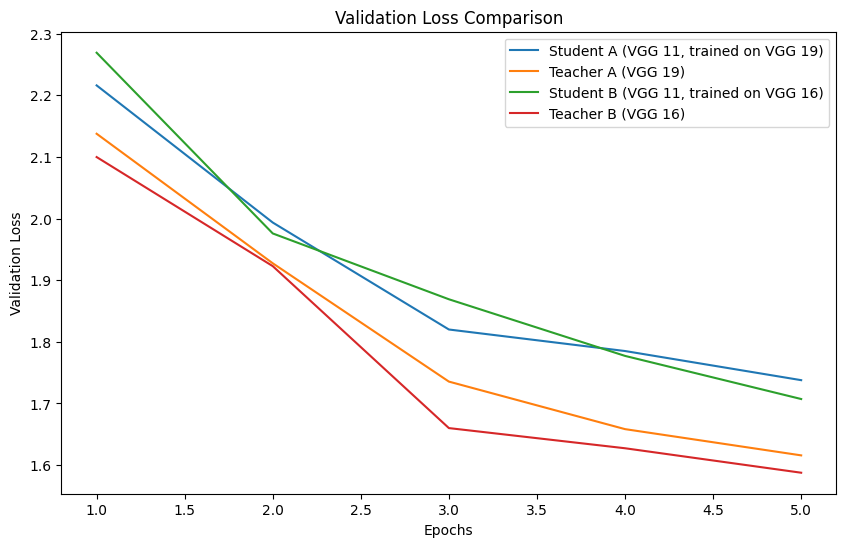

In [14]:

# Plot Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, lm_val_losses, label="Student A (VGG 11, trained on VGG 19)")
plt.plot(epochs, teacher_val_losses, label="Teacher A (VGG 19)")
plt.plot(epochs, lmB_val_losses, label="Student B (VGG 11, trained on VGG 16)")
plt.plot(epochs, teacherB_val_losses, label="Teacher B (VGG 16)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()


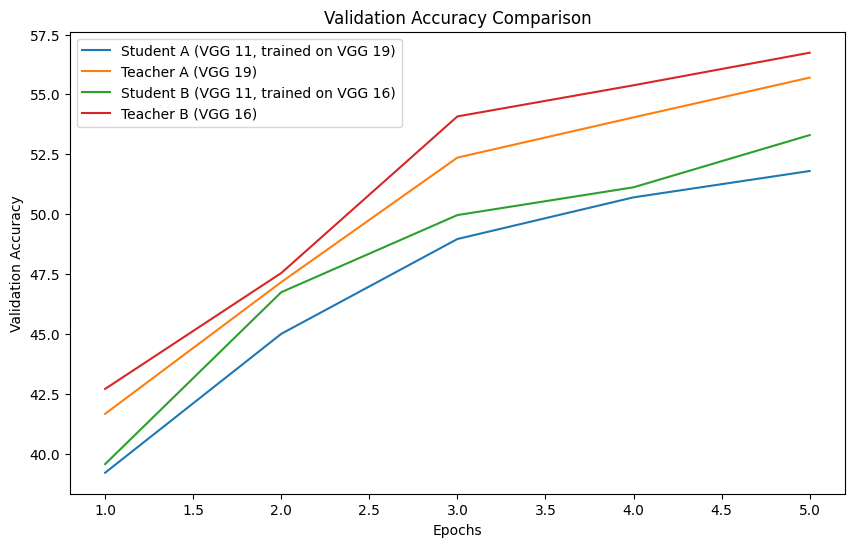

In [15]:

# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, lm_val_accuracies, label="Student A (VGG 11, trained on VGG 19)")
plt.plot(epochs, teacher_val_accuracies, label="Teacher A (VGG 19)")
plt.plot(epochs, lmB_val_accuracies, label="Student B (VGG 11, trained on VGG 16)")
plt.plot(epochs, teacherB_val_accuracies, label="Teacher B (VGG 16)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()


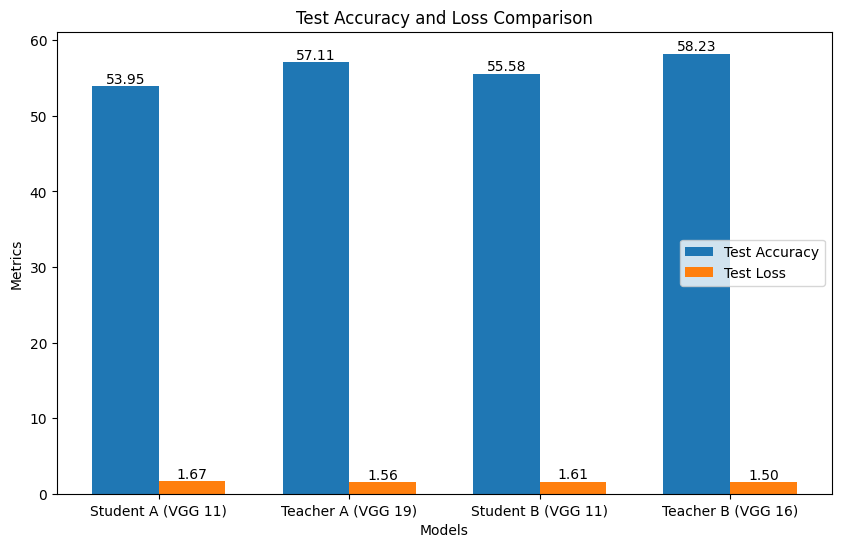

In [16]:

# Plot Test Accuracy and Loss as bar chart with values above each bar
plt.figure(figsize=(10, 6))
model_names = ["Student A (VGG 11)", "Teacher A (VGG 19)", "Student B (VGG 11)", "Teacher B (VGG 16)"]
test_accuracies = [lm_test_accuracy, teacher_test_accuracy, lmB_test_accuracy, teacherB_test_accuracy]
test_losses = [lm_test_loss, teacher_test_loss, lmB_test_loss, teacherB_test_loss]

bar_width = 0.35
index = range(len(model_names))

bars1 = plt.bar(index, test_accuracies, bar_width, label='Test Accuracy')
bars2 = plt.bar([i + bar_width for i in index], test_losses, bar_width, label='Test Loss')
plt.xlabel("Models")
plt.ylabel("Metrics")
plt.title("Test Accuracy and Loss Comparison")
plt.xticks([i + bar_width / 2 for i in index], model_names)
plt.legend(loc="center right")

# Add values above each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha="center", va="bottom")

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha="center", va="bottom")

plt.show()
